In [1]:
import pickle
import gzip
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from PIL import Image
import os
import numpy as np
np.random.seed(666)

In [2]:
filename = '../mnist.pkl.gz'
f = gzip.open(filename, 'rb')
training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
f.close()

In [3]:
# Functions
def one_hot_vect(tuple_data,classes):
    one_hot_encoded=np.zeros((len(tuple_data[1]),len(classes)))
    identity = np.identity(len(classes))
    for i in range(len(tuple_data[1])):
        one_hot_encoded[i] = np.add(one_hot_encoded[i],identity[tuple_data[1][i]])
    return one_hot_encoded

def softmax(weights,train_data):
    bias = np.ones((np.shape(train_data)[0],1))
    train_withBias = np.hstack((train_data,bias))
    num = np.dot(weights,train_withBias.T)
    # High value Fix
    # https://houxianxu.github.io/2015/04/23/logistic-softmax-regression/
    num = np.subtract(num,np.max(num,axis=0))
    num = np.exp(num)
    # Fix softmax when using batch size 1 the dimension of deno changes
    if(len(train_data) == 1):
        deno = np.sum(num,axis=0)
    else:
        deno = np.sum(num,axis=1)
        deno = deno.reshape((10,1))
    return np.divide(num,deno)

def cross_entropy_error(predicted,target):
    right = np.log(predicted+ 1/10**30)
    loss = np.multiply(np.matrix(target),np.transpose(np.matrix(right)))
    return -np.sum(np.sum(loss,axis=1),axis=0)

def batch_gradient(predicted,train_data,target):
    leftleft = np.transpose(predicted)
    left = np.subtract(leftleft,target)
    bias = np.ones((np.shape(train_data)[0],1))
    train_withBias = np.hstack((train_data,bias))
    gradient = np.dot(left.T,train_withBias)
    gradient = gradient/len(train_data)
    return np.matrix(gradient,dtype="float64")

def accuracy(predicted,target):
    correct = 0
    left = np.array(np.argmax(predicted,axis=0)).flatten()
    right = np.argmax(target,axis=1)
    confusion_mat = np.zeros((len(np.unique(right)),len(np.unique(left))))
    for i in range(len(target)):
        if(left[i] == right[i]):
            correct+=1
        confusion_mat[left[i]][right[i]] =confusion_mat[left[i]][right[i]] +1
    return correct/len(target),pd.DataFrame(np.matrix(confusion_mat,dtype="int32"))

def more_metrics(conf_mat):
    true_positives = 0
    precision = []
    recall = []
    for i in range(len(conf_mat)):
        true_positives += conf_mat.iloc[i,i]
    conf_mat = np.matrix(conf_mat)
    tp_fp = np.array(np.sum(conf_mat,axis=1)).ravel()
    relevant_elements = np.array(np.sum(conf_mat,axis=0)).ravel()
    for i in range(len(conf_mat)):
        precision.append(conf_mat[i,i]/tp_fp[i])
        recall.append(conf_mat[i,i]/relevant_elements[i])
    return true_positives,precision,recall

def epoch_shuffle(processed_train_data,target):
    # Merge
    trainDF = pd.DataFrame(processed_train_data)
    targetDF = pd.DataFrame(target)
    result = pd.concat([trainDF.reset_index(),targetDF.reset_index()],join='inner',axis=1)
    result = result.sample(frac=1)
    
    return np.asarray(result.iloc[:,1:np.shape(trainDF)[1]+1]),np.asarray(result.iloc[:,np.shape(trainDF)[1]+2:])

In [4]:
# Fixed Var
classes = np.unique(training_data[1])
weights = np.random.randn(len(classes), np.shape(training_data[0])[1]+1) * 0.001
train_data = training_data[0]

In [5]:
target = one_hot_vect(training_data,classes)
target_val = one_hot_vect(validation_data,classes)
target_test = one_hot_vect(test_data,classes)
scaler = StandardScaler()
scaler.fit(train_data)
processed_train_data = scaler.transform(train_data)
scaler.fit(validation_data[0])
processed_val_data = scaler.transform(validation_data[0])
scaler.fit(test_data[0])
processed_test_data = scaler.transform(test_data[0])

In [9]:
i = 0
batchSize = 1
start = 0
end = batchSize
batches = len(processed_train_data)/batchSize
weights = np.random.randn(len(classes), np.shape(training_data[0])[1]+1) * 0.001
predicted = softmax(weights,processed_train_data[start:end,:])
cost_initial = np.asscalar(cross_entropy_error(softmax(weights,processed_train_data),target))
cost_new = cost_initial*0.1
train_acc = 0
log_training_loss =[]
log_val_loss=[]
log_training_acc =[]
log_val_acc=[]
logging=True
while(cost_initial-cost_new > 10):
    i = 0
    start = 0
    end = batchSize
    while(i<batches-1):
        #print("Percentage Done: "+str(i/batches))
        new_weights = batch_gradient(predicted,processed_train_data[start:end,:],target[start:end,:])
        weights = weights - 0.0003*new_weights
        if(logging and i%2500==0):
            # Predict Train & Validation for these weights
            predict_val = softmax(weights,processed_val_data)
            # Calculate cost of predicting Validation and Training, To see if the hyper param are working
            acc,_  = accuracy(predict_val,target_val)
            log_val_acc.append(acc)
            log_val_loss.append(np.asscalar(cross_entropy_error(predict_val,target_val)))
            predict_train = softmax(weights,processed_train_data)
            acc,_  = accuracy(predict_train,target)
            log_training_acc.append(acc)
            log_training_loss.append(np.asscalar(cross_entropy_error(predict_train,target)))
        #print("Training Loss: "+str(cost))
        start = start + batchSize
        end = end + batchSize
        # New Prediction for the data
        predicted = softmax(weights,processed_train_data[start:end,:])
        i = i+1
    cost_initital = cost_new
    pred_train = softmax(weights,processed_train_data)
    cost_new = np.asscalar(cross_entropy_error(pred_train,target))
    predict_val = softmax(weights,processed_val_data)
    val_acc,_ = accuracy(predict_val,target_val)
    train_acc_old = train_acc
    train_acc,_ = accuracy(pred_train,target)
    if(float(train_acc) - float(train_acc_old) < 0.000001 ):
        # Early stopping where just cost is changing but accuracy is stuck
        break
    print("Cost after Epoch: "+str(cost_new))
    print("Val Acc: "+str(val_acc))
    print("Train Acc: "+str(train_acc))
    processed_train_data,target = epoch_shuffle(processed_train_data,target)

Cost after Epoch: 444385.19880386314
Val Acc: 0.9154
Train Acc: 0.90866
Cost after Epoch: 442525.8262796829
Val Acc: 0.9205
Train Acc: 0.9169
Cost after Epoch: 441727.7940376019
Val Acc: 0.9232
Train Acc: 0.91998
Cost after Epoch: 441202.9493963989
Val Acc: 0.9241
Train Acc: 0.92228
Cost after Epoch: 440860.60391310754
Val Acc: 0.9251
Train Acc: 0.92464
Cost after Epoch: 440632.9338020989
Val Acc: 0.9255
Train Acc: 0.9252
Cost after Epoch: 440346.9963194856
Val Acc: 0.9266
Train Acc: 0.92676
Cost after Epoch: 440211.79270796926
Val Acc: 0.9266
Train Acc: 0.92786
Cost after Epoch: 440048.27950384043
Val Acc: 0.9265
Train Acc: 0.92886
Cost after Epoch: 439931.09701448807
Val Acc: 0.9264
Train Acc: 0.92906
Cost after Epoch: 439823.12912905205
Val Acc: 0.9265
Train Acc: 0.92996
Cost after Epoch: 439715.87774746254
Val Acc: 0.9275
Train Acc: 0.93088
Cost after Epoch: 439604.4995487535
Val Acc: 0.9268
Train Acc: 0.93098
Cost after Epoch: 439492.6712532519
Val Acc: 0.9284
Train Acc: 0.93126
C

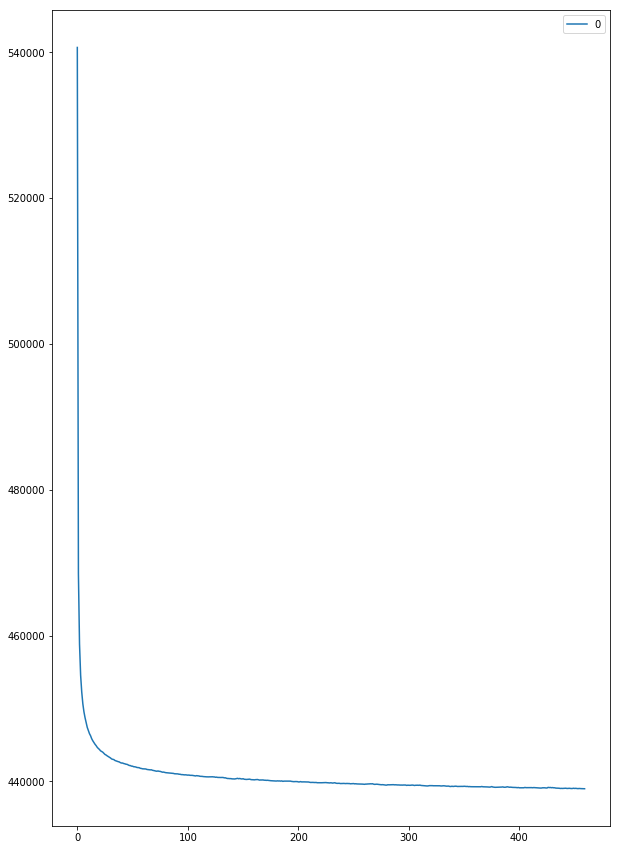

In [11]:
df = pd.DataFrame(log_training_loss)
ax = df.plot(figsize=(10,15))
ax.ticklabel_format(useOffset=False)
plt.savefig('./train_loss.png',bbox_inches='tight')
plt.show(ax)

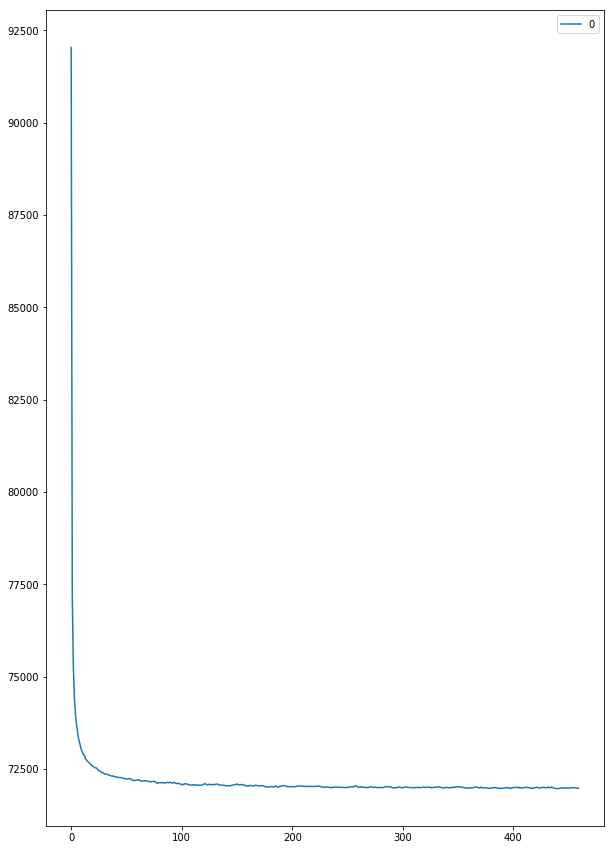

In [13]:
df = pd.DataFrame(log_val_loss)
ax = df.plot(figsize=(10,15))
ax.ticklabel_format(useOffset=False)
plt.savefig('./val_loss.png',bbox_inches='tight')
plt.show(ax)

In [14]:
predict_val = softmax(weights,processed_val_data)
accuracy(predict_val,target_val)

(0.9281,      0     1    2    3    4    5    6     7    8    9
 0  962     0    3    5    1    9    3     3    3    4
 1    0  1043   12    4   10    3    5     5   29    5
 2    6     4  903   14    3   12    7     5    7    2
 3    1     2   11  918    2   32    0     6   16    8
 4    3     1   12    1  928    7    6     6    2   23
 5    5     5    5   43    0  792    6     0   27    7
 6    7     0    6    4    6   30  937     0    6    1
 7    4     1   15    6    5    6    1  1034    9   32
 8    3     7   20   25    2   20    2     1  890    5
 9    0     1    3   10   26    4    0    30   20  874)

In [15]:
predict_test = softmax(weights,processed_test_data)
accuracy(predict_test,target_test)

(0.9246,      0     1    2    3    4    5    6    7    8    9
 0  955     0    7    3    2    8   11    2    5   10
 1    0  1106    8    1    4    3    4    9   10    7
 2    1     4  936   20    8    2    8   21    8    1
 3    1     2   12  914    1   34    1    7   17   10
 4    3     1    9    1  915    7    7    6   10   26
 5    7     1    4   27    1  781   12    1   31    6
 6    7     4   12    3    8   18  911    0   11    0
 7    4     2   12   12    5    7    2  953   14   24
 8    2    15   31   21    7   27    2    2  857    7
 9    0     0    1    8   31    5    0   27   11  918)

In [133]:
true_positives,precision,recall = more_metrics(conf_mat)

NameError: name 'conf_mat' is not defined

# USPS Data Test

In [16]:
USPSMat  = []
USPSTar  = []
curPath  = '../USPSdata/Numerals'
savedImg = []

for j in range(0,10):
    curFolderPath = curPath + '/' + str(j)
    imgs =  os.listdir(curFolderPath)
    for img in imgs:
        curImg = curFolderPath + '/' + img
        if curImg[-3:] == 'png':
            img = Image.open(curImg,'r')
            img = img.resize((28, 28))
            savedImg = img
            imgdata = (255-np.array(img.getdata()))/255
            USPSMat.append(imgdata)
            USPSTar.append(j)

In [17]:
target_USPS = one_hot_vect((1,USPSTar),classes)
scaler.fit(USPSMat)
processed_USPSDat = scaler.transform(USPSMat)


In [18]:
predict_USPS = softmax(weights,processed_USPSDat)
accuracy(predict_USPS,target_USPS)

(0.3336666833341667,      0    1     2    3    4    5    6    7    8    9
 0  526   55    81   75   35  143   85  137  233   36
 1   20  324    77   77   98   71   18  205   70  138
 2  152  224  1125  161   33  193  382   43   64   58
 3   66  246   100  888   27  134   77  381  269  413
 4  134  321    32   18  949   38   60   59  142  113
 5  127  108   144  414   64  870  312  100  337   29
 6  195   37   175   42   64  222  780   28  198   19
 7  285  185    26   44  179   72   57  343   86  382
 8  120  349   176  215  306  209   62  477  432  376
 9  375  151    63   66  245   48  167  227  169  436)